<a href="https://colab.research.google.com/github/s-gil/Nerves/blob/main/Intro_Ciencia_Datos_Taller1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  **Taller 1: Analisis Descriptivo (univariado y multivariado)**

##Importar Datos
Los datos requeridos se encuentran en un repositorio de github, por lo que es necesario utilizar las siguintes funciones para importarlos.

In [ ]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import requests, zipfile, io

r = requests.get( 'https://github.com/s-gil/Nerves/blob/main/USImages.zip?raw=true' ) 
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

En el explorador de archivos debe aparcer una carpeta llamada *USImages*, donde estarán almacenados los datos.

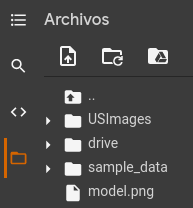

## Base de Datos

La base de datos se genera a partir de imágenes de ultrasonido correspondientes a planos anatómicos pertinentes para la realización del bloqueo de nervios periféricos. En este caso: nervio mediano y nervio cubital en el antebrazo.
Las imágenes de ultrasonido fueron tomadas de pacientes hombres y mujeres mayores de 18 años en quienes se tenía planeado realizar la identificación de estructuras nerviosas mediante ecografía, debido a que se someterían al procedimiento de Bloqueo de Nervios Periféricos (PNB) por parte de un anestesiólogo.

Se obtuvieron en total 48 imágenes de ultrasonido, para las cuales se definió una region de interés (ROI) a partir de la etiqueta del especialista, y se realizó una segmentación a partir del agrupamiento de diferentes píxeles llamdos superpíxeles. 
En la siguiente figura se muestra el proceso descrito, realizado a una de las imágenes de ultrasonido originales.

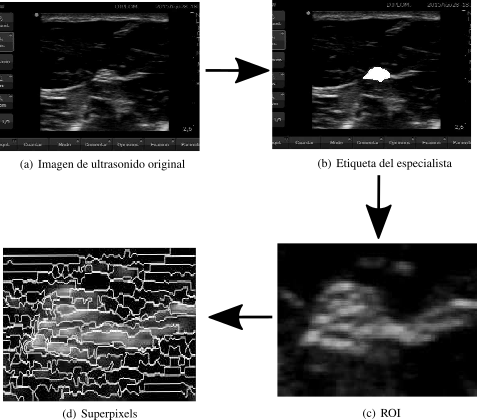

Posteriormente, se realiza una etapa de estimación de características sobre
cada uno de los superpixeles calculados con el fin de diferenciar una estructura nerviosa de otras estructuras anatómicas. Para esto, se utiliza la transformada Wavelet adaptativa, la cual es una extensión de la transformada Wavelet discreta donde los parámetros de los filtros asociadas a esta se ven afectados por las características locales de la imagen. De este modo, cada superpixel es representado por 4 bandas obtenidas a partir de la transformada wavelet, y se extrae de cada una de las 4 bandas de representación la media, desviación estándar y entropía.

Finalmente, se obtienen los siguientes conjuntos de datos:

$\bullet Ic:$ Conjunto de imágenes originales de la sección de interés.

$\bullet Sp:$ Conjunto de superpixeles.

$\bullet X:$ Conjunto de características extraídas a los superpixeles.

$\bullet T:$ Conjunto de anotadores.

El conjunto $X$ contiene datos estructurados contenidos en un arreglo. Todas las variables son de tipo cuantitativas y continuas.

El conjunto $T$ contiene datos estructurados de tipo cualitativo y nominal.

In [ ]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

Ic = scipy.io.loadmat('USImages/ImGC.mat')["Ic"]
Sp = scipy.io.loadmat('USImages/UIdatasetSP600FM.mat')["sp"]
X = scipy.io.loadmat('USImages/UIdatasetSP600FM.mat')["X"]
T = scipy.io.loadmat('USImages/UIdatasetSP600FM.mat')["T"]

print("Tamaño de Ic:",Ic.shape)
print("Tamaño de Sp:",Sp.shape)
print("Tamaño de X:",X.shape)
print("Tamaño de T:",T.shape)

Tamaño de Ic: (48, 1)
Tamaño de Sp: (48, 1)
Tamaño de X: (28037, 12)
Tamaño de T: (28037, 3)


##Conjunto de etiquetas
Como cada superpixel tiene tres anotadores asociados, se hace el promedio entre los tres anotadores y se genera una etiqueta por cada superpixel.

In [ ]:
T = np.round(np.mean(T,axis=1))
T = T.astype(int)
print("Tamaño de T:",T.shape)

Tamaño de T: (28037,)


#Análisis Univariado
Se genera un dataframe a partir del conjunto de datos $X$, y se obtienen la media y varianza de cada una de los atributos. Puede observarse que la media del atributo $e_3$ es la menor, y presenta además la menor varianza.
Así mismo, $m_1$ presenta los mayores valores de media y varianza. Esto puede ser verificado visualmente en los *scatter_plot* de cada uno de estos atributos. Debido a que éstos daos corresponden a estadísticos obtenidos a partir de transformaciones realizadas a un conjunto de imágenes, su interpretabilidad se pierde.  

Mean: 

m1    68.072735
e1     3.148750
m2    18.599768
e2     3.367849
m3     5.441324
e3     1.156414
m4     7.291720
e4     1.979846
dtype: float64 

Var: 

m1    5467.795731
e1       2.532261
m2     384.758707
e2       2.340703
m3     351.185417
e3       1.635428
m4     248.963570
e4       2.034433
dtype: float64


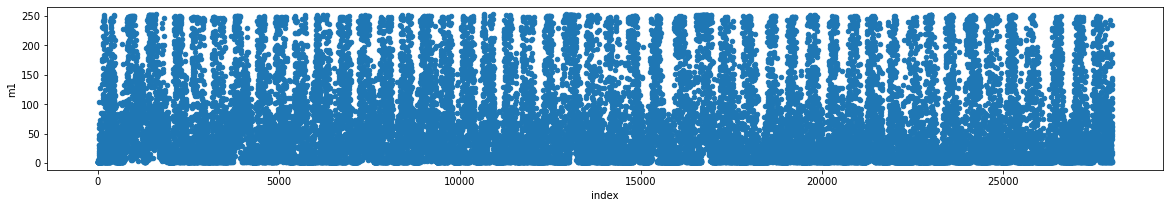

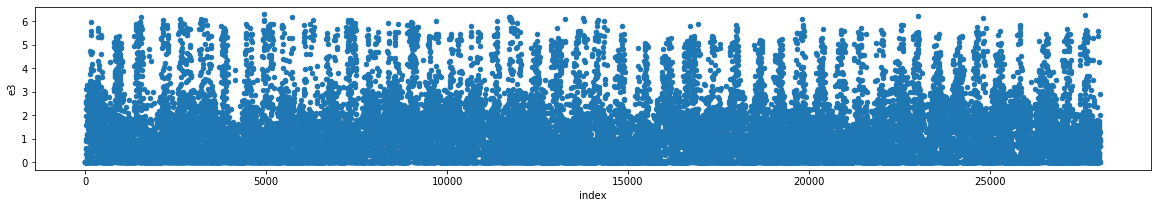

In [ ]:
import pandas as pd
from pandas.plotting import scatter_matrix

X_df = pd.DataFrame(X, columns=["m1", "std1","e1", "m2","std2", "e2","m3", "std3","e3", "m4","std4", "e4"])
# X_df.insert(12,"T",T)
del X_df["std1"]
del X_df["std2"]
del X_df["std3"]
del X_df["std4"]

X_mean = X_df.mean(axis = 0) 
X_var = X_df.var(axis = 0) 
print("Mean: \n")
print(X_mean, "\n")
print("Var: \n")
print(X_var)

X_df.insert(8,"index",X_df.index.values)
X_df.plot.scatter("index","m1",figsize=(20,3))
X_df.plot.scatter("index","e3",figsize=(20,3))
del X_df["index"]

##Outliers
Para la detección de valores atípicos de cada uno de los atributos del conjunto $X$, se utiliza la función ***isoutlier*** de Matlab con todos los métodos disponibles (mean, median, quartiles, gesd, grubbs). Se obtienen los conjuntos *mean, median, quartiles, gesd y grubbs* que tiene la misma forma de $X$ y contienen solo ceros y unos para indicar si el valor de $X$ en esa posición coresponde o no a un outlier.

Para visualizar la diferencia entre los métodos, se grafican todos los elementos del atributo $m_2$ en un scatter_plot para cada uno de los métodos. Los puntos azules representan los valores que no son outliers y los rojos los que si lo son.


In [ ]:
# X_df.boxplot(column=["m1","e1", "m2","e2","m3","e3", "m4","e4"], figsize=(10,3))
mean=scipy.io.loadmat('USImages/outliers')["mean"]
median=scipy.io.loadmat('USImages/outliers')["median"]
quartiles=scipy.io.loadmat('USImages/outliers')["quartiles"]
gesd=scipy.io.loadmat('USImages/outliers')["gesd"]
grubbs=scipy.io.loadmat('USImages/outliers')["grubbs"]

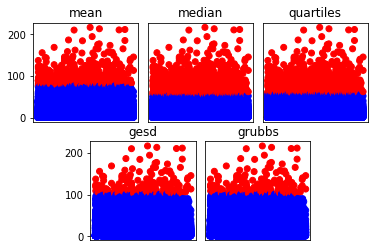

In [ ]:
x=np.arange(0,X.shape[0],1)
colormap = np.array(['b','r'])
ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2,)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)
ax1.set_title("mean")
ax1.get_xaxis().set_ticks([])
ax2.set_title("median")
ax2.get_xaxis().set_ticks([])
ax2.get_yaxis().set_ticks([])
ax3.set_title("quartiles")
ax3.get_yaxis().set_ticks([])
ax3.get_xaxis().set_ticks([])
ax4.set_title("gesd")
ax4.get_xaxis().set_ticks([])
ax5.set_title("grubbs")
ax5.get_xaxis().set_ticks([])
ax5.get_yaxis().set_ticks([])
ax1.scatter(x, X[:,3], c=colormap[mean[:,3]])
ax2.scatter(x, X[:,3], c=colormap[median[:,3]])
ax3.scatter(x, X[:,3], c=colormap[quartiles[:,3]])
ax4.scatter(x, X[:,3], c=colormap[gesd[:,3]])
ax5.scatter(x, X[:,3], c=colormap[grubbs[:,3]])

En la anterior gráfica es posible observar que cada método genera un "umbral" a partir del cual clasifica cada dato como atípico o no atípico. los métodos más flexibles son ***gesd y grubbs***, y el que más outliers clasificó fue ***median***.

Por otro lado, la función ***boxplot*** de matplotlib.pyplot permite generar un diagrama de caja y bigote, donde es posible visualizar el primer cuartil, segundo cuartil o mediana, y tercer cuartil de los datos. A partir de estos valores se puede determinar la simetría de la distribución de los datos.
Además, con este diagrama posible identificar los límites de detcción de valores atípicos a través de los bigotes. Esta función utiliza el método ***quartiles*** para la detección de los outliers. 

La siguiente figura corresponde a el boxplot de cada uno de los atributos del conjunto $X$. Puede notarse que $m1$ presenta los valores más altos y no fueron detectados outliers, mientras que para $m3$ se identificaron una gran cantidad. Así mismo para $e3$ es posible afirmar que el 50% de los datos se encuentran entre 0 y 2 aproximadamente. 

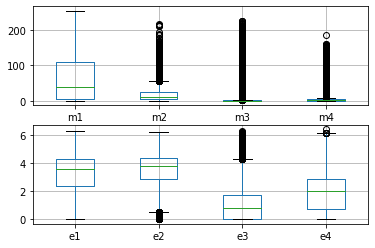

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2)
X_df.boxplot(column=["m1","m2","m3","m4"],ax=ax1)
X_df.boxplot(column=["e1","e2","e3","e4"],ax=ax2)

##Prueba de Normalidad
Para determinar si los datos siguen una distribución normal, se utilizan el ***coeficiente de asimetría (Skewness)*** y la ***Kurtosis***. 

Si el skewness es igual a cero, los datos son perfectamente simétricos.

Si el skewness es menor que -1 o mayor que 1, la distribución es extremadamente sesgada.

Si el skewness se encuentra entre -1 y -0,5 o entre 0,5 y 1, la distribución es moderadamente sesgada.

Si el skewness se encuentra entre -0,5 y 0,5, la distribución es aproximadamente sesgada.

Si la kurtosis es mayor a cero, existe una gran concentración de los valores en torno a su media.

Si la kurtosis es igual a cero, existe una concentración normal de los valores en torno a su media.

Si la kurtosis es menor a cero, existe una baja concentración de los valores en torno a su media.

A continuación, se obtienen las medidas de kurtosis y skewness para cad uno de los atributos del conjunto $X$, y se genera un histograma para algunos atributos con el fin de compararlos con los valores obtenidos.

Skewness
m1    1.062179
e1   -0.840045
m2    2.277586
e2   -1.056270
m3    6.629978
e3    1.456280
m4    4.382881
e4    0.298765
dtype: float64 

Kurtosis
m1    -0.051693
e1    -0.427489
m2     8.587181
e2     0.172860
m3    50.564494
e3     1.926114
m4    22.772034
e4    -0.526983
dtype: float64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb649cb1278>,
      dtype=object)

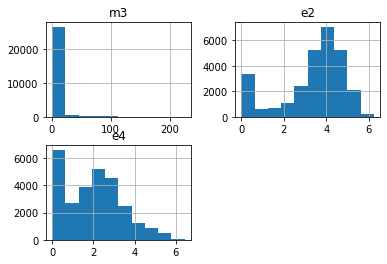

In [ ]:
print("Skewness")
print(X_df.skew(axis=0),"\n")
print("Kurtosis")
print(X_df.kurtosis(axis=0))
X_df.hist(["m3","e2","e4"])

Como puede observarse en la anterior gráfica, $m3$ tiene una distribución muy sesgada y la mayor parte de los datos están concentrados en torno a su media. 
Esto puede ser corroborado con sus valores de skewness (6.62), kurtosis (50,56) y media (5.54). 

Por su parte, $e2$, cuyo valor de media es 3.36, también tiene una distribución sesgada pero en sentido opuesto y mucho menor a la de $e3$. Además, sus datos tiene una distribución más similar a la normal alrededor de la media.

Finalmente, el histograma de $e4$ nos permite ver que éste atributo tiene na distrubución muy poco sesgada, es decir que los datos son son muy simétricos, teniendo en cuenta que su media es 1.97. Además, la concentración de sus datos alrededor de la media es similar a una distribución normal.

##Análisis de variable categórica
En las siguientes figuras se representa la cantidad de de etiquetas de la clase 1 (nervio) y la clase 0 (no nervio). Como puede observarse, la cantidad de datos que son 0, supera en gran medida a los que son 1. Esto representa un desbalanceo importante en los datos, ya que no existe equilibrio entre la cantidad de datos de cada clase.


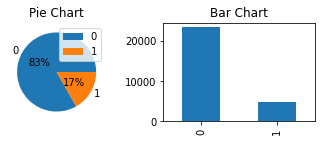

In [ ]:
T_df = pd.DataFrame(T, columns=["T"])
plt.subplot(221)
T_df["T"].value_counts().plot(kind='pie',autopct='%1.0f%%', pctdistance=0.5)
plt.title('Pie Chart')
plt.xlabel('')
plt.ylabel('')
plt.legend()
plt.subplot(222)
plt.title('Bar Chart')
T_df["T"].value_counts().plot(kind='bar')

##Discretización
A continuación, se elige la variable numérica $e3$, y se realizan  diferentes procesos de discretización.

Primero se realiza la discretización no supervisada de ancho uniforme, para la cual se eligen dos y tres intervalos que tendrán el mismo ancho y difreente cantidad de datos. Se puede notar que a medida que se aumenta el numero de intervalos, los datos se distribuyen entre estos.

Posteriormente se realiza la discretización no supervisada de frecuencia uniforme, para la cual se eligen dos y tres intervalos que tendrán la misma frecuencia pero no el mismo ancho. Este proceso permite obtener grupos con la misma cantidad de datos.


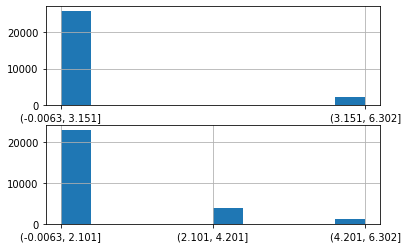

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2)
X_df['binned'] = pd.cut(X_df["e3"], 2,labels=["(-0.0063, 3.151]","(3.151, 6.302]"])
X_df["binned"].hist(ax=ax1)
X_df['binned'] = pd.cut(X_df["e3"], 3,labels=["(-0.0063, 2.101]","(2.101, 4.201]","(4.201, 6.302]"])
X_df["binned"].hist(ax=ax2)


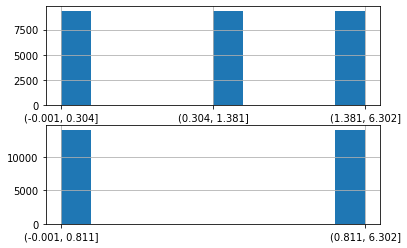

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2)
X_df["binned"]=pd.qcut(X_df["e3"],3, labels=["(-0.001, 0.304]","(0.304, 1.381]","(1.381, 6.302]"])
X_df["binned"].hist(ax=ax1)
X_df["binned"]=pd.qcut(X_df["e3"],2, labels=["(-0.001, 0.811]","(0.811, 6.302]"])
X_df["binned"].hist(ax=ax2)

##Análisis de Correlación
Para visualizar la relación que existe entre cada uno de los atributos de la base $X$, se realiza un ***scatter_plot*** para todas las parejas de variables que puedan formarse. Además, para verificar la información proporcionada por ésta gráfica, se obtienen los índices de correlación entre los atributos.

Como puede observarse en la gráfica, el scatter_plot que relaciona los atributos $e3, e4$, y el que relaciona $e1,e2$ muestran una correlación alta entre las variables, es decir, a medida que crecen los valores de uno de los atributos, tabién crecen los valores del otro.

En general, la mayoria de los scatter muestran una relación lineal entre las variables, unas más altas que otras, y unas pocas aparentemente sin ninguna correlación como $m3,e2$.


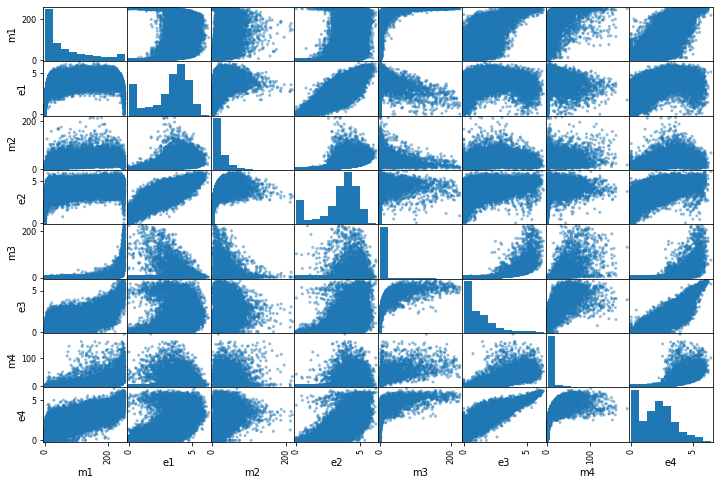

,m1,e1,m2,e2,m3,e3,m4,e4
m1,1.000000,0.510341,0.545036,0.533190,0.502827,0.823483,0.612307,0.799261
e1,0.510341,1.000000,0.500347,0.922790,-0.002821,0.450887,0.146350,0.686338
m2,0.545036,0.500347,1.000000,0.550203,0.142598,0.486737,0.409280,0.581055
e2,0.533190,0.922790,0.550203,1.000000,0.135916,0.508694,0.235965,0.720868
m3,0.502827,-0.002821,0.142598,0.135916,1.000000,0.622238,0.710705,0.454450
e3,0.823483,0.450887,0.486737,0.508694,0.622238,1.000000,0.693899,0.869664
m4,0.612307,0.146350,0.409280,0.235965,0.710705,0.693899,1.000000,0.600100
e4,0.799261,0.686338,0.581055,0.720868,0.454450,0.869664,0.600100,1.000000


In [ ]:
attributes = ["m1","e1","m2","e2","m3","e3","m4","e4"]
scatter_matrix(X_df[attributes], figsize=(12, 8))
plt.show()
X_df.corr()

En la anterior tabla se muestran los índices de correlación entre cada par de atributos. Esta información muestra concretamente el grado y tipo de correlación existente. Las vriables $e2,e1$ presentan la mayor correlación positiva, mientras que $e1,m3$ la menor y la única negativa. 

En conclusión, aunque la exploración visual permite tener cierta noción de la correlación entre variables, es necesario calcular el índice para obtener la información verdadera.

##Covarianza
Para realizar el cálculo de la correlación entre dos variables, es necesario calcular primero el valor de covarianza entre éstas. Teniendo en cuenta ésto, se calculan los valores de covarianza para cada pareja de atributos del conjunto $X$, con el fin de observar cómo influye el vaor de la covarianza en el índice de correlación.

In [ ]:
X_df.cov()

,m1,e1,m2,e2,m3,e3,m4,e4
m1,5467.795731,60.051136,790.543633,60.319981,696.775780,77.871166,714.402968,84.297874
e1,60.051136,2.532261,15.617807,2.246623,-0.084125,0.917566,3.674640,1.557808
m2,790.543633,15.617807,384.758707,16.511651,52.417578,12.209676,126.672516,16.256721
e2,60.319981,2.246623,16.511651,2.340703,3.896835,0.995281,5.696251,1.573080
m3,696.775780,-0.084125,52.417578,3.896835,351.185417,14.912153,210.148204,12.147190
e3,77.871166,0.917566,12.209676,0.995281,14.912153,1.635428,14.001668,1.586313
m4,714.402968,3.674640,126.672516,5.696251,210.148204,14.001668,248.963570,13.505584
e4,84.297874,1.557808,16.256721,1.573080,12.147190,1.586313,13.505584,2.034433


Como puede observarse, la covarianza entre los atributos $m3,e1$ es la única con el valor negativo, igual que el índice de correlación. Además, al analizar el scatter_plot entre éstas variables, es posible distinguir que mientras una de las variables crece la otra tiene cierta tendencia a decrecer.  

A partir de ésto puede confirmar que el signo de la covarinza determina el tipo de relación entre las variables, es decir:

Relación directa: Si $A$ decrece, $B$ decrece ,ó, si $A$ crece $B$ crece (covarianza positiva).  

Relación indirecta: Si $A$ decrece, $B$ crece ,ó, si $A$ crece $B$ decrece (covarianza negativa).  

##Reresión Lineal
A partir de los índices de correlación se eligen los atributos $e1$ y $e2$ para realizar una regresión lineal, tomando el primero como el conjunto de características y el segundo como el conjunto de etiquetas.

Para esto, primero es necesario partir los datos en conjuntos de entrenamiento y prueba. Este paso requiere de la discretización del conjunto de etiquetas para posteriormnete hacer una partición estratificada que conserve la proporción en los datos sugún su distribución.

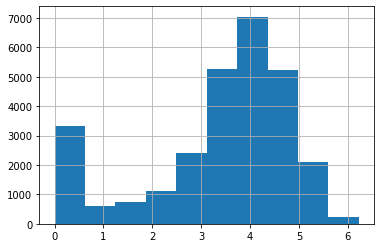

In [ ]:
X_df["e2"].hist()

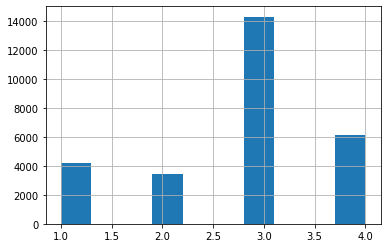

In [ ]:
X_df["e2_cat"] = pd.cut(X_df["e2"],  #e2 discretizada
                               bins=[-np.inf, 1.5, 3.0, 4.5, np.inf],
                               labels=[1, 2, 3, 4])
X_df["e2_cat"].hist()

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(X_df, X_df["e2_cat"]):
    strat_train_set = X_df.loc[train_index]
    strat_test_set = X_df.loc[test_index]

Después de realizar la partición de los datos, se verifica que si se hayan tomado las mismas proporciones con relación al conjunto de datos original.

In [ ]:
strat_train_set["e2_cat"].value_counts() / len(strat_train_set)

3    0.509430
4    0.219002
1    0.149851
2    0.121717
Name: e2_cat, dtype: float64

In [ ]:
X_df["e2_cat"].value_counts() / len(X_df["e2_cat"])

3    0.509434
4    0.218996
1    0.149838
2    0.121732
Name: e2_cat, dtype: float64

Después de dividir los datos, se entrena el modelo de regresión, se obtiene los parámetros (pendiente e intercepto) y se realiza lagráfica de los datos originales y del modelo de regresión lineal.
Puede observarse en la gráfica que el modelo sigue la tendencia de los datos originales.

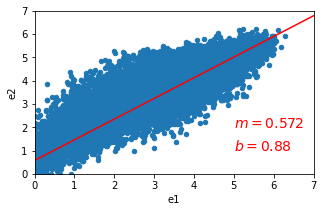

In [ ]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(np.c_[strat_train_set["e1"]], np.c_[strat_train_set["e2"]])
t0, t1 = reg.intercept_[0], reg.coef_[0][0]

strat_train_set.plot(kind='scatter', x="e1", y='e2', figsize=(5,3)) #figura de los datos originales
plt.axis([0, 7, 0, 7])
x=np.linspace(0, 7, 7)
plt.plot(x, t0 + t1*x, "r") #gráfica del modelo obtenido
plt.text(5, 2, r"$m = 0.572$", fontsize=14, color="r")
plt.text(5, 1, r"$b = 0.88 $", fontsize=14, color="r")
plt.show()

Finalmente, se valida el modelo a partir de la predicción sobre el conjunto de prueba. 
Para evaluar la calidad del ajuste se obtiene el error estándar de los residuos (RSE), el cual representa la cantidad media que la respuesta se desviará de los datos reales. Su valor depende de la dimensión del eje y [1]. 
En este caso, el eje Y está entre cero y un poco más de 6, por lo que el RSE presenta valores bajos que no implican la ausencia de error.
Si se realiza un procesamiento sobre los datos, es posible que pueda mejorarse le error de predicción. Una opción puede ser eliminar los outliers.

[1]. A., 'Regresión lineal en Python', 2018. [Online]. Available: https://machinelearningparatodos.com/regresion-lineal-en-python/.

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
strat_test_set["e2_pred"]=reg.predict(np.c_[strat_test_set["e1"]])
# reg.score(np.c_[strat_test_set["e1"]], np.c_[strat_test_set["e2"]])
mse = mean_squared_error(np.c_[strat_test_set["e2"]],np.c_[strat_test_set["e2_pred"]])
print("RSE:",np.sqrt(mse/(strat_test_set["e2"].shape[0]-2)))
del X_df["e2_cat"]

RSE: 0.007906323426922228


##Prueba T-Student
Para realizar el t-test pareado, se eligen los atributos $e1$ y $e2$, con media 3.14 y 3.36 respectivamente. 
El objetivo es saber si la diferencia entre las medias de  cada atributo está por encima o por debajo del intervalo de confianza, es decir, si esa diferencia es estadisticamente significativa. El valor típico de $\alpha$ es 0.05. Esto representa que para un 95% de la confianza los esquemas si son significativamente distintos.

Según la documentación para la función ***stats.ttest_ind***, "Si observamos un valor p grande, por ejemplo mayor que 0.05 o 0.1, entonces no podemos rechazar la hipótesis nula de puntajes promedio idénticos. Si el valor p es menor que el umbral, p. Ej. 1%, 5% o 10%, luego rechazamos la hipótesis nula de promedios iguales." [2]

[2]. "scipy.stats.ttest_ind¶". [Online]. Available: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html



In [ ]:
from scipy import stats
print("t-test pareado para variables con medias diferentes:",stats.ttest_ind(X_df["e1"],X_df["e2"]))
print("t-test pareado para variables con medias idénticas:",stats.ttest_ind(X_df["e1"],X_df["e1"]))

t-test pareado para variables con medias diferentes: Ttest_indResult(statistic=-16.619137113389595, pvalue=7.127341154574145e-62)
t-test pareado para variables con medias idénticas: Ttest_indResult(statistic=0.0, pvalue=1.0)


Para realizar la prueba t-student univariada, se elige el atributo $e2$ y se suponen valores de la media esperada con el fin de observar la diferencia.
Puede observarse, el el valor ***pvalue*** es mayor cuando la media esperada es muy similar a la media real, permitiendo aceptar la hipótesis nula.

In [ ]:
print("Media esperada: 3.36",stats.ttest_1samp(X_df["e2"], popmean=3.36))
print("Media esperada: 3.0",stats.ttest_1samp(X_df["e2"], popmean=3.0))

Media esperada: 3.36 Ttest_1sampResult(statistic=0.8590089113515593, pvalue=0.390342943830595)
Media esperada: 3.0 Ttest_1sampResult(statistic=40.258910748530184, pvalue=0.0)


##Análisis de Componente Principal
A continuación, se realiza la descomposición del conjunto $X$, y se representa a través de 4 componentes que explican el 92.9 porciento de la varianza. Con tres componentes se explica el 88.3 porciento.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
X_s = StandardScaler().fit_transform(X_df[["m1","e1","m2","e2","m3","e3","m4","e4"]]) # Standarización de los datos de X
pca = PCA(n_components=4)
PCA = pca.fit_transform(X_s)
X_df['PCA_1'], X_df['PCA_2'], X_df['PCA_3'], X_df['PCA_4']  = [PCA[:,0], PCA[:,1], PCA[:,2],PCA[:,3]] #Añadir columnas de PCA al conjunto X
print("Varianza explicada:",pca.explained_variance_ratio_)

Posteriormente se grafican los datos de cada uno de los Componentes principales contra el resto, teniendo en cuenta las dos clases. Puede observarse que los datos no son para nada separables. 

In [ ]:
def plot_pca(pca1,pca2,ax):
  targets = [0,1]
  colors = ['r', 'g']
  for target, color in zip(targets,colors):
      indicesToKeep = T_df['T'] == target
      ax.scatter(X_df.loc[indicesToKeep, pca1]
                , X_df.loc[indicesToKeep, pca2]
                , c = color
                , s = 50)
  ax.legend(targets)
  ax.grid()

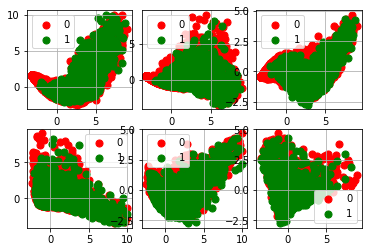

In [ ]:
ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2,)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax4 = plt.subplot2grid((2,6), (1,0), colspan=2)
ax5 = plt.subplot2grid((2,6), (1,2), colspan=2)
ax6 = plt.subplot2grid((2,6), (1,4), colspan=2)

plot_pca("PCA_1","PCA_2",ax1)
plot_pca("PCA_1","PCA_3",ax2)
plot_pca("PCA_1","PCA_4",ax3)
plot_pca("PCA_2","PCA_3",ax4)
plot_pca("PCA_2","PCA_4",ax5)
plot_pca("PCA_3","PCA_4",ax6)

X_df=X_df.drop(["PCA_1","PCA_2","PCA_3","PCA_4"],axis=1) # Eliminar columnas

#Redes Neuronales
Con el fin de generar un modelo que permita la clasificación de datos como nervio o no nervio, se utilizan el conjunto de características $X$ y el conjunto de superpixeles $Sp$ y redes neuronales.

##Organización de superpíxeles
Primero, se desarrolla un método para agregar un fondo a todos los superpíxeles con el fin de que tengan el mismo tamaño.
Este paso es necesario, ya que las redes neuronales requieren que los datos de entrada tengan el mismo tamaño.

In [ ]:
size = []
spx = []
shape = [30,36]
for i in range(Sp.shape[0]):
  for j in range(np.max(Sp[i][0])):
    indices=np.where(Sp[i][0]==j+1)
    ind_min = [np.min(indices[0]),np.min(indices[1])]
    ind_max = [np.max(indices[0]),np.max(indices[1])]
    tam = [ind_max[0]- ind_min[0]+1,ind_max[1]- ind_min[1]+1]
    shift = [int((shape[0]-tam[0])/2),int((shape[1]-tam[1])/2)]
    backgnd = np.zeros((shape[0],shape[1]))
    for k in range(len(indices[0])):
      backgnd[indices[0][k]-ind_min[0]+shift[0],indices[1][k]-ind_min[1]+shift[1]] = Ic[i][0][indices[0][k]][indices[1][k]]
    spx.append(backgnd)

In [ ]:
print("Tamaño de Sp:",len(backgnd_list))
print("Pimer elemneto de Sp:",backgnd_list[100].shape,"\n",backgnd_list[100])

Tamaño de Sp: 28037
Pimer elemneto de Sp: (30, 36) 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


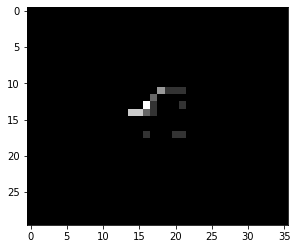

In [ ]:
plt.imshow(spx[101],cmap="gray")

Como puede observarse, el superpixel, que antes estaba conformado por la figura que se genera en el centro de la anterior imagen, ahora tiene un fondo negro. Así mismo se modificaron todos los superpixeles y ahora todos tienen el mismo tamaño. De esta manera se construye el conjunto $spx$

##Red Neuronal con el conjunto $X$
La primera red neuronal se implementa utilizando el conjunto de características $X$. 

Para esto, primero es necesario analizar y discretizar el conjunto de etiquetas $T$, con el fin de hacer una división estratificada de los datos y así obtener los conjuntos de entrenamiento y prueba. 

Se aprovecha éste paso para también dividir los conjuntos de superpixeles $Sp$ y etiquetas $T$ con base en la discretización realizada.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa599d88c18>]],
      dtype=object)

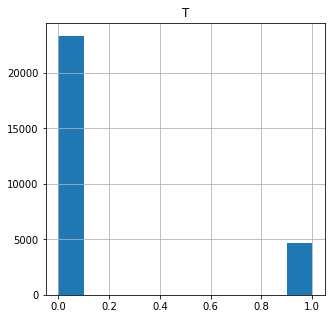

In [ ]:
T_df.hist(bins=10, figsize=(5,5),column=["T"],grid=True)

In [ ]:
# Discretización del conjunto de etiquetas
T_df["T_cat"] = pd.cut(T_df["T"],
bins=[-np.inf, 0.5, np.inf], labels=[1, 2])
T_df["T_cat"].value_counts()

1    23342
2     4695
Name: T_cat, dtype: int64

In [ ]:
# Partición de los datos
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(X, T_df["T_cat"]):
    strat_train_set = X_df.iloc[train_index]   # X_train
    strat_test_set = X_df.iloc[test_index]     # X_test

    sp_train_set=np.asarray(spx)[train_index]  # Sp_train
    sp_test_set=np.asarray(spx)[test_index]    # Sp_test

    T_train_set=np.c_[T[train_index]]          # T_train
    T_test_set=np.c_[T[test_index]]            # T_test

In [ ]:
#Proporción de datos de clase 0 y la clase 1 en los conjuntos X,spx y T
(T_df["T"][train_index]==0).value_counts()/len(T_df["T"][train_index])

True     0.832538
False    0.167462
Name: T, dtype: float64

In [ ]:
#Proporción de datos de clase 0 y 1 en el conjunto T discretizado.
T_df["T_cat"].value_counts()/ len(T_df)

1    0.832543
2    0.167457
Name: T_cat, dtype: float64

In [ ]:
df["T_bin"].value_counts() / len(df)

1    0.832543
2    0.167457
Name: T_bin, dtype: float64

##Arquitectura y entrenamiento de las Redes Neuronales
Para la arquitectura de las redes, se define un modelo secuencial con diferentes capas y funciones de activación, teniendo en cuenta que se trata de un problema de clasificación de dos clases.

##Conjunto de características $X$

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
red1 (Dense)                 (None, 100)               900       
_________________________________________________________________
hred4 (Dense)                (None, 50)                5050      
_________________________________________________________________
output (Dense)               (None, 1)                 51        
Total params: 6,001
Trainable params: 6,001
Non-trainable params: 0
_________________________________________________________________


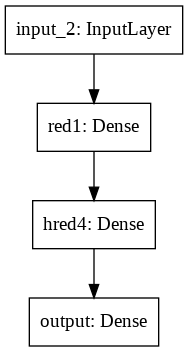

In [ ]:
import tensorflow as tf
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(8)), #Tamaño del conjunto X (8 caracteristicas)
    tf.keras.layers.Dense(100,activation="relu", name='red1'),
    tf.keras.layers.Dense(50, activation="relu",name='hred4'),
    tf.keras.layers.Dense(1,activation='sigmoid',name='output') 
])
model.summary()
tf.keras.utils.plot_model(model)

In [ ]:
from sklearn.preprocessing import StandardScaler

model.compile(loss="binary_crossentropy", #custom_loss(),#custom_loss(),#"sparse_categorical_crossentropy",
              optimizer="Adam",
              metrics="accuracy") #f1, precision, recall, crossentropy

In [ ]:
history = model.fit(strat_train_set, T_train_set, epochs=10,batch_size=128)

Epoch 1/10
176/176 [==============================] - 0s 1ms/step - loss: 0.6332 - accuracy: 0.8230
Epoch 2/10
176/176 [==============================] - 0s 1ms/step - loss: 0.3162 - accuracy: 0.8629
Epoch 3/10
176/176 [==============================] - 0s 2ms/step - loss: 0.3007 - accuracy: 0.8636
Epoch 4/10
176/176 [==============================] - 0s 1ms/step - loss: 0.2947 - accuracy: 0.8641
Epoch 5/10
176/176 [==============================] - 0s 1ms/step - loss: 0.2956 - accuracy: 0.8651
Epoch 6/10
176/176 [==============================] - 0s 1ms/step - loss: 0.2952 - accuracy: 0.8648
Epoch 7/10
176/176 [==============================] - 0s 1ms/step - loss: 0.2942 - accuracy: 0.8640
Epoch 8/10
176/176 [==============================] - 0s 1ms/step - loss: 0.2909 - accuracy: 0.8650
Epoch 9/10
176/176 [==============================] - 0s 1ms/step - loss: 0.2925 - accuracy: 0.8652
Epoch 10/10
176/176 [==============================] - 0s 1ms/step - loss: 0.2899 - accuracy: 0.8660

In [ ]:
model.evaluate(strat_test_set, T_test_set)
# accuracy = model.evaluate(x_test,t_test)

176/176 [==============================] - 0s 887us/step - loss: 0.2997 - accuracy: 0.8532


[0.29968592524528503, 0.8532453775405884]

##Conjunto de Superpixeles
A diferencia del conjunto de características, el conjunto de entrenamiento de superpixeles tiene un tamaño de (22429, 30, 36); por lo tanto es necesario utilizar la función ***Flatten*** para vectorizar cada elemento.

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 49)                0         
_________________________________________________________________
red1 (Dense)                 (None, 200)               10000     
_________________________________________________________________
hred4 (Dense)                (None, 50)                10050     
_________________________________________________________________
output (Dense)               (None, 1)                 51        
Total params: 20,101
Trainable params: 20,101
Non-trainable params: 0
_________________________________________________________________


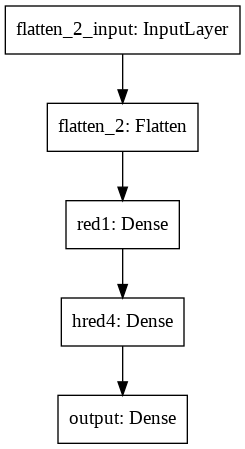

In [ ]:
#definir arquitectura secuencial
import tensorflow as tf
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(sp_train_set.shValoresape[1],sp_train_set.shape[2])),
    tf.keras.layers.Dense(200,activation="relu", name='red1'),
    tf.keras.layers.Dense(50, activation="relu",name='hred4'),
    tf.keras.layers.Dense(1,activation='sigmoid',name='output')
])

model.summary()
tf.keras.utils.plot_model(model)

In [ ]:
from sklearn.preprocessing import StandardScaler

model.compile(loss="binary_crossentropy", #custom_loss(),#custom_loss(),#"sparse_categorical_crossentropy",
              optimizer="Adam",
              metrics="accuracy") #f1, precision, recall, crossentropy


In [ ]:
history = model.fit(sp_train_set, T_train_set, epochs=10, batch_size=128) # 32, 64, 128, 256)

Epoch 1/10
176/176 [==============================] - 0s 1ms/step - loss: 0.4969 - accuracy: 0.8367
Epoch 2/10
176/176 [==============================] - 0s 1ms/step - loss: 0.3199 - accuracy: 0.8625
Epoch 3/10
176/176 [==============================] - 0s 1ms/step - loss: 0.3170 - accuracy: 0.8595
Epoch 4/10
176/176 [==============================] - 0s 1ms/step - loss: 0.3082 - accuracy: 0.8617
Epoch 5/10
176/176 [==============================] - 0s 1ms/step - loss: 0.3075 - accuracy: 0.8595
Epoch 6/10
176/176 [==============================] - 0s 1ms/step - loss: 0.3027 - accuracy: 0.8611
Epoch 7/10
176/176 [==============================] - 0s 1ms/step - loss: 0.2971 - accuracy: 0.8632
Epoch 8/10
176/176 [==============================] - 0s 1ms/step - loss: 0.2964 - accuracy: 0.8635
Epoch 9/10
176/176 [==============================] - 0s 1ms/step - loss: 0.2975 - accuracy: 0.8620
Epoch 10/10
176/176 [==============================] - 0s 1ms/step - loss: 0.2909 - accuracy: 0.8647

In [ ]:
model.evaluate(strat_test_set, T_test_set)
# accuracy = model.evaluate(x_test,t_test)

176/176 [==============================] - 0s 756us/step - loss: 0.2821 - accuracy: 0.8709


[0.28205442428588867, 0.8708987236022949]

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
clf = DecisionTreeClassifier(random_state=0)
clf = clf.fit(strat_train_set, T_train_set)

res_pred = clf.predict(strat_test_set)
score = accuracy_score(T_test_set, res_pred)
score

array([0.57359973, 0.20821189, 0.06901825])